# Imports

In [1]:
!pip install adabound

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras.preprocessing import image
import pandas as pd
import numpy as np
import cv2
import imageio
from PIL import Image
from sklearn.utils import class_weight
import numpy as np
from keras import layers, Input, utils
from keras.models import Model

# Global variables


In [3]:
BATCH_SIZE = 128
TOT_DATA = 11199
EPOCHS = 30
VALIDATION_SPLIT = 0.3
directory = "../Rub7/light"
tot_train = TOT_DATA*(1-VALIDATION_SPLIT)
tot_val = TOT_DATA*VALIDATION_SPLIT
img_dim = (128,128)


#Creating train and val set

In [4]:
image_generator = image.ImageDataGenerator(rescale = 1. /255, validation_split = VALIDATION_SPLIT, preprocessing_function = None )
train_data = image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                 directory = directory, 
                                                 subset = "training", 
                                                 shuffle = True, 
                                                 target_size = (128,128), 
                                                 class_mode = "categorical")
validation_data = image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                      directory = directory,
                                                      subset = "validation",
                                                      shuffle = True,
                                                      target_size = (128,128),
                                                      class_mode = "categorical")
print(train_data.classes)

Found 9101 images belonging to 3 classes.
Found 3899 images belonging to 3 classes.
[0 0 0 ... 2 2 2]


##Classes weights

In [5]:
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_data.classes), 
            train_data.classes)
weight = {i : class_weights[i] for i in range(3)}
print(weight)

{0: 0.6466993533717047, 1: 1.3561317240351662, 2: 1.3960730173339468}


C:\Users\USER\anaconda3\envs\tensorflow-cpu\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 2 2 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


#Model

In [6]:
# taken from https://iq.opengenus.org/vgg19-architecture/
from keras import backend as K
#K.set_image_data_format('th')

tot_train = TOT_DATA*(1-VALIDATION_SPLIT)
tot_val = TOT_DATA*VALIDATION_SPLIT

model = models.Sequential([
                           layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
                           layers.Conv2D(64, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),

                           layers.Conv2D(128, (3, 3), activation='relu'),
                           layers.Conv2D(128, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),         

                           layers.Conv2D(256, (3, 3), activation='relu'),
                           #layers.Conv2D(256, (3, 3), activation='relu'),
                           #layers.Conv2D(256, (3, 3), activation='relu'),
                           layers.Conv2D(256, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),

                           layers.Conv2D(512, (3, 3), activation='relu'),
                           #layers.Conv2D(512, (3, 3), activation='relu'),
                           #layers.Conv2D(521, (3, 3), activation='relu'),
                           layers.Conv2D(521, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),
                           
                           layers.Flatten(),
                           layers.Dense(4096, activation='relu'),
                           layers.Dropout(0.4),
                           layers.Dense(4096, activation='relu'),
                           layers.Dropout(0.4),
                           layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [7]:
from keras.utils import plot_model
plot_model(model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [9]:
history = model.fit(train_data, 
                    epochs=EPOCHS, 
                    class_weight=weight,
                    steps_per_epoch=int(np.ceil(tot_train / BATCH_SIZE)), 
                    validation_data=validation_data, 
                    validation_steps=int(np.ceil(tot_val / float(BATCH_SIZE)))) #10 epochs instead of 20


Epoch 1/30
62/62 [==============================] - 1383s 22s/step - loss: 0.5996 - accuracy: 0.7516 - val_loss: 0.5360 - val_accuracy: 0.8056
Epoch 2/30
62/62 [==============================] - 1354s 22s/step - loss: 0.5573 - accuracy: 0.7784 - val_loss: 0.4814 - val_accuracy: 0.8293
Epoch 3/30
62/62 [==============================] - 1351s 22s/step - loss: 0.5210 - accuracy: 0.7886 - val_loss: 0.4203 - val_accuracy: 0.8472
Epoch 4/30
62/62 [==============================] - 1350s 22s/step - loss: 0.5167 - accuracy: 0.7941 - val_loss: 0.3867 - val_accuracy: 0.8698
Epoch 5/30
62/62 [==============================] - 1352s 22s/step - loss: 0.4910 - accuracy: 0.8002 - val_loss: 0.3573 - val_accuracy: 0.8721
Epoch 6/30
62/62 [==============================] - 1351s 22s/step - loss: 0.4709 - accuracy: 0.8041 - val_loss: 0.3844 - val_accuracy: 0.8689
Epoch 7/30
62/62 [==============================] - 1350s 22s/step - loss: 0.4632 - accuracy: 0.8100 - val_loss: 0.3957 - val_accuracy: 0.8507

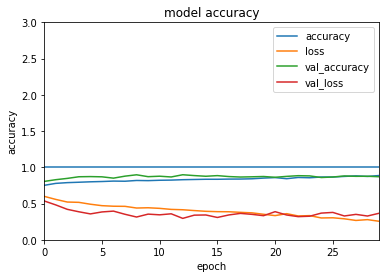

In [10]:
plt.plot(history.history['accuracy'])  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_accuracy'])  
plt.plot(history.history['val_loss']) 
plt.hlines(1, 0, EPOCHS)
plt.axis([0,EPOCHS-1, 0, 3]) 
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['accuracy', 'loss','val_accuracy', 'val_loss'], loc='best') 

## Save Model


In [ ]:
import os

save_path = "../light/vgg19"

if not os.path.exists(save_path) :
  os.makedirs(save_path)

final_inception_model.save(save_path)

# Orientation

In [ ]:
directory = "../Rub7/orientation"

In [ ]:
image_generator = image.ImageDataGenerator(rescale = 1. /255, validation_split = VALIDATION_SPLIT, preprocessing_function = None )
train_data = image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                 directory = directory, 
                                                 subset = "training", 
                                                 shuffle = True, 
                                                 target_size = (128,128), 
                                                 class_mode = "categorical")
validation_data = image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                      directory = directory,
                                                      subset = "validation",
                                                      shuffle = True,
                                                      target_size = (128,128),
                                                      class_mode = "categorical")
print(train_data.classes)

class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_data.classes), 
            train_data.classes)
weight = {i : class_weights[i] for i in range(3)}
print(weight)

In [ ]:
model = models.Sequential([
                           layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
                           layers.Conv2D(64, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),

                           layers.Conv2D(128, (3, 3), activation='relu'),
                           layers.Conv2D(128, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),         

                           layers.Conv2D(256, (3, 3), activation='relu'),
                          #  layers.Conv2D(256, (3, 3), activation='relu'),
                          #  layers.Conv2D(256, (3, 3), activation='relu'),
                           layers.Conv2D(256, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),

                           layers.Conv2D(512, (3, 3), activation='relu'),
                          #  layers.Conv2D(512, (3, 3), activation='relu'),
                          #  layers.Conv2D(521, (3, 3), activation='relu'),
                           layers.Conv2D(521, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),
                           
                           layers.Flatten(),
                           layers.Dense(4096, activation='relu'),
                           layers.Dropout(0.4),
                           layers.Dense(4096, activation='relu'),
                           layers.Dropout(0.4),
                           layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data,
                    epochs=EPOCHS,
                    class_weight=weight,
                    steps_per_epoch=int(np.ceil(tot_train / BATCH_SIZE)), 
                    validation_data=validation_data,
                    validation_steps=int(np.ceil(tot_val / float(BATCH_SIZE)))) #10 epochs instead of 20


In [ ]:
plt.plot(history.history['accuracy'])  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_accuracy'])  
plt.plot(history.history['val_loss']) 
plt.hlines(1, 0, EPOCHS)
plt.axis([0,EPOCHS-1, 0, 3]) 
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['accuracy', 'loss','val_accuracy', 'val_loss'], loc='best')

In [ ]:
import os

save_path = "../orientation/vgg19"

if not os.path.exists(save_path) :
  os.makedirs(save_path)

final_inception_model.save(save_path)